#ENGR 8140 - Advanced Deep Learning & Engineering Applications
## Assignment 2 - Image Classification
In this assignment, you will practice on image classification using the CIFAR-10 dataset.
The codes for data downloading and processing are provided below. Note the train dataset is further split into train_ds and val_ds and three dataloaders (i.e., train_loader, val_loader, and test_loader) are created for training, validation, and testing, respectively.

You will need to complete the following tasks:

(1) Code the MnasNet-A1 (shown below, ref: https://arxiv.org/abs/1807.11626) in PyTorch by following the similar coding style as the examples shown in "NB6_ModernCNNs.ipynb". Specifically, you will need to "modularize" your codes, i.e., define proper "classes" and/or "functions" for different blocks as shown in Figure 7 below (e.g., MBConv3, MBConv6, and SepConv) and then use them to construct your model architecture.

(2) Train the MnasNet-A1 using CIFAR-10.

(3) Evaluate your model and report performance on the test dataset.


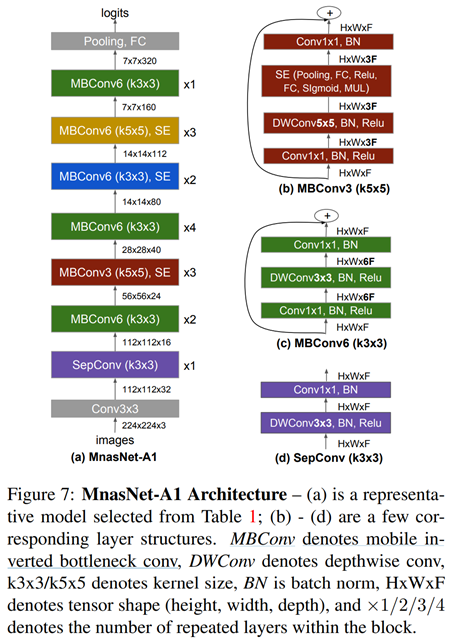

In [41]:
# !nvidia-smi
# !pip install accelerate -U
# !pip show accelerate
# !pip install git+https://github.com/huggingface/accelerate
# !pip install ptflops
# print("pip done")

In [42]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

from torchvision.models import resnet50
from ptflops import get_model_complexity_info

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch.optim as optim

import os

# # Accelerate parts
# from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
# from accelerate.utils import set_seed # reproducability across devices

In [43]:
params_config = [
    {"batch_size": 1024,  "max_epoch": 60,    "learning_rate": 0.015,        "loss_function": nn.CrossEntropyLoss(),     "optimizer": optim.Adam},
]

In [44]:
def get_dataloaders(batch_size):
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    cf10_transforms = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    train = CIFAR10(root='./data', train=True, download=True, transform=cf10_transforms)
    test = CIFAR10(root='./data', train=False, download=True, transform=cf10_transforms)
    
    ##################################################################################
    print(train.classes)
    
    torch.manual_seed(42)
    val_size = 5000
    train_size = len(train) - val_size

    ##################################################################################
    
    # 'random_split' is a PyTorch function that randomly splits a dataset into non-overlapping new datasets
    # The lengths of the splits are provided as a list: [train_size, val_size]
    train_ds, val_ds = random_split(train, [train_size, val_size])
    len(train_ds), len(val_ds)
    
    ##################################################################################
    
    # Create a DataLoader for the training dataset
    # shuffle=True will shuffle the dataset before each epoch
    # num_workers=2 will use two subprocesses for data loading
    # pin_memory=True will copy Tensors into CUDA pinned memory before returning them
    train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader, train.classes

In [45]:
# # Only execute if necessary

# train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)
# print(len(classes))

# for images, _ in train_loader:
#     print('images.shape:', images.shape)
#     plt.figure(figsize=(32,32))
#     plt.axis('off')
#     plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
#     break

# # make_grid() arranges images into a grid
# # permute() changes the order of tensor dimensions to fit what imshow expects (height, width, channels)

## Your codes go here:
### (1) Define the model

In [46]:
class SepConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(SepConv, self).__init__()
        # Depthwise convolution followed by BatchNorm and ReLU
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=kernel_size//2, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        # Pointwise convolution followed by BatchNorm without ReLU
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )      

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduced_channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc_reduce = nn.Conv2d(in_channels, reduced_channels, 1, bias=False)
        self.fc_expand = nn.Conv2d(reduced_channels, in_channels, 1, bias=False)

    def forward(self, x):
        se_weight = self.avg_pool(x)
        se_weight = F.relu(self.fc_reduce(se_weight))
        se_weight = torch.sigmoid(self.fc_expand(se_weight))
        return x * se_weight


class MBConv3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=3):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion_factor
      
        self.expand_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        
        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size, stride=stride, padding=1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )
        self.se_block = SEBlock(mid_channels, reduced_channels=mid_channels // 4) # Why through 4??
        
        self.project_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.se_block(x)
        x = self.project_conv(x)
        return x


class MBConv6(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
        super().__init__()
        self.use_residual = stride == 1 and in_channels == out_channels
        mid_channels = in_channels * expansion_factor

        self.expand_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels, kernel_size, stride=stride, padding=2, groups=mid_channels, bias=False), # padding=2 to keep the same size ???
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True)
        )

        self.project_conv = nn.Sequential(
            nn.Conv2d(mid_channels, out_channels, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = self.expand_conv(x)
        x = self.depthwise_conv(x)
        x = self.project_conv(x)     
        return x
    
class MBConv6_SE(MBConv6):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
        super().__init__(in_channels, out_channels, kernel_size, stride, expansion_factor=6)
        self.se_block = SEBlock(out_channels, reduced_channels=out_channels // 4) # Why through 4??

    def forward(self, x):
        x = super().forward(x)
        x = self.se_block(x)
        return x
    
# ----------------------------------------------------------------------------------------------
# class MBConv6(nn.Module):
#     def _init_(self, in_channels, out_channels, kernel_size, stride, expansion_factor=6):
    
# class MBConv3(nn.Module):
#     def _init_(self, in_channels, out_channels, kernel_size, stride, expansion_factor=3):
# ----------------------------------------------------------------------------------------------

# Define the MnasNet-A1 model
class MnasNetA1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Initial 3x3 convolution
        self.initial_conv = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # Initial separable convolution
        self.sep_conv = SepConv(32, 16, 3)
        # Sequence of MBConv blocks
        self.blocks = nn.Sequential(
            MBConv6(16, 24, kernel_size=3, stride = 2),
            MBConv6(24, 24, kernel_size=3, stride = 1),
            
            MBConv3(24, 40, kernel_size=3, stride = 2),
            MBConv3(40, 40, kernel_size=3, stride = 1),
            MBConv3(40, 40, kernel_size=3, stride = 1),
            
            MBConv6(40, 80, kernel_size=3, stride = 2),
            MBConv6(80, 80, kernel_size=3, stride = 1),
            MBConv6(80, 80, kernel_size=3, stride = 1),
            MBConv6(80, 80, kernel_size=3, stride = 1),

            MBConv6_SE(80, 112, kernel_size=3, stride = 1),
            MBConv6_SE(112, 112, kernel_size=3, stride = 1),

            MBConv6_SE(112, 160, kernel_size=5, stride = 2),
            MBConv6_SE(160, 160, kernel_size=5, stride = 2),
            MBConv6_SE(160, 160, kernel_size=5, stride = 2),

            MBConv6(160, 320, kernel_size=3, stride = 1),
        )

        # Final separable convolution
        self.final_conv = SepConv(320, 320, 3)
        # Fully connected layer
        self.fc = nn.Linear(320, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.sep_conv(x)
        x = self.blocks(x)
        x = self.final_conv(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

### (2) Train the model using train and val datasets

cuda
Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Epoch 1/60: 100%|██████████| 44/44 [00:19<00:00,  2.28batch/s, accuracy=17.1, loss=0.00209]


Epoch 1/60, Train Loss: 0.00, Train acc: 17.11, Val Loss: 0.00, 'Val acc: 22.84%', 


Epoch 2/60: 100%|██████████| 44/44 [00:19<00:00,  2.25batch/s, accuracy=26.7, loss=0.00177]


Epoch 2/60, Train Loss: 0.00, Train acc: 26.71, Val Loss: 0.00, 'Val acc: 33.28%', 


Epoch 3/60: 100%|██████████| 44/44 [00:19<00:00,  2.21batch/s, accuracy=36.7, loss=0.00156]


Epoch 3/60, Train Loss: 0.00, Train acc: 36.72, Val Loss: 0.00, 'Val acc: 40.94%', 


Epoch 4/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=44.7, loss=0.00142]


Epoch 4/60, Train Loss: 0.00, Train acc: 44.71, Val Loss: 0.00, 'Val acc: 48.02%', 


Epoch 5/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=51.3, loss=0.00129]


Epoch 5/60, Train Loss: 0.00, Train acc: 51.29, Val Loss: 0.00, 'Val acc: 53.48%', 


Epoch 6/60: 100%|██████████| 44/44 [00:20<00:00,  2.12batch/s, accuracy=56.3, loss=0.00116]


Epoch 6/60, Train Loss: 0.00, Train acc: 56.35, Val Loss: 0.00, 'Val acc: 57.64%', 


Epoch 7/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=59.7, loss=0.00108]


Epoch 7/60, Train Loss: 0.00, Train acc: 59.72, Val Loss: 0.00, 'Val acc: 60.38%', 


Epoch 8/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=62.7, loss=0.00101]


Epoch 8/60, Train Loss: 0.00, Train acc: 62.70, Val Loss: 0.00, 'Val acc: 60.74%', 


Epoch 9/60: 100%|██████████| 44/44 [00:19<00:00,  2.20batch/s, accuracy=64.3, loss=0.000973]


Epoch 9/60, Train Loss: 0.00, Train acc: 64.33, Val Loss: 0.00, 'Val acc: 62.98%', 


Epoch 10/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=66.4, loss=0.000916]


Epoch 10/60, Train Loss: 0.00, Train acc: 66.36, Val Loss: 0.00, 'Val acc: 65.76%', 


Epoch 11/60: 100%|██████████| 44/44 [00:20<00:00,  2.13batch/s, accuracy=68.6, loss=0.00086] 


Epoch 11/60, Train Loss: 0.00, Train acc: 68.62, Val Loss: 0.00, 'Val acc: 66.52%', 


Epoch 12/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=69.4, loss=0.00084] 


Epoch 12/60, Train Loss: 0.00, Train acc: 69.44, Val Loss: 0.00, 'Val acc: 66.74%', 


Epoch 13/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=70.7, loss=0.000807]


Epoch 13/60, Train Loss: 0.00, Train acc: 70.71, Val Loss: 0.00, 'Val acc: 67.16%', 


Epoch 14/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=72.1, loss=0.000775]


Epoch 14/60, Train Loss: 0.00, Train acc: 72.07, Val Loss: 0.00, 'Val acc: 68.12%', 


Epoch 15/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=72.6, loss=0.000753]


Epoch 15/60, Train Loss: 0.00, Train acc: 72.65, Val Loss: 0.00, 'Val acc: 69.60%', 


Epoch 16/60: 100%|██████████| 44/44 [00:20<00:00,  2.13batch/s, accuracy=74.4, loss=0.000708]


Epoch 16/60, Train Loss: 0.00, Train acc: 74.45, Val Loss: 0.00, 'Val acc: 70.12%', 


Epoch 17/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=75.3, loss=0.000687]


Epoch 17/60, Train Loss: 0.00, Train acc: 75.26, Val Loss: 0.00, 'Val acc: 69.68%', 


Epoch 18/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=76.1, loss=0.000661]


Epoch 18/60, Train Loss: 0.00, Train acc: 76.10, Val Loss: 0.00, 'Val acc: 71.00%', 


Epoch 19/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=76.8, loss=0.000647]


Epoch 19/60, Train Loss: 0.00, Train acc: 76.84, Val Loss: 0.00, 'Val acc: 71.02%', 


Epoch 20/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=77.3, loss=0.00063] 


Epoch 20/60, Train Loss: 0.00, Train acc: 77.26, Val Loss: 0.00, 'Val acc: 72.00%', 


Epoch 21/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=78.3, loss=0.000606]


Epoch 21/60, Train Loss: 0.00, Train acc: 78.26, Val Loss: 0.00, 'Val acc: 71.28%', 


Epoch 22/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=78.5, loss=0.000602]


Epoch 22/60, Train Loss: 0.00, Train acc: 78.47, Val Loss: 0.00, 'Val acc: 71.56%', 


Epoch 23/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=79.1, loss=0.000584]


Epoch 23/60, Train Loss: 0.00, Train acc: 79.08, Val Loss: 0.00, 'Val acc: 72.54%', 


Epoch 24/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=79.9, loss=0.000559]


Epoch 24/60, Train Loss: 0.00, Train acc: 79.94, Val Loss: 0.00, 'Val acc: 72.00%', 


Epoch 25/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=80.6, loss=0.000548]


Epoch 25/60, Train Loss: 0.00, Train acc: 80.63, Val Loss: 0.00, 'Val acc: 72.96%', 


Epoch 26/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=80.5, loss=0.000541]


Epoch 26/60, Train Loss: 0.00, Train acc: 80.54, Val Loss: 0.00, 'Val acc: 72.02%', 


Epoch 27/60: 100%|██████████| 44/44 [00:20<00:00,  2.13batch/s, accuracy=81.1, loss=0.000528]


Epoch 27/60, Train Loss: 0.00, Train acc: 81.11, Val Loss: 0.00, 'Val acc: 72.76%', 


Epoch 28/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=81.7, loss=0.000513]


Epoch 28/60, Train Loss: 0.00, Train acc: 81.67, Val Loss: 0.00, 'Val acc: 72.88%', 


Epoch 29/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=82.6, loss=0.000492]


Epoch 29/60, Train Loss: 0.00, Train acc: 82.55, Val Loss: 0.00, 'Val acc: 73.72%', 


Epoch 30/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=82.6, loss=0.000486]


Epoch 30/60, Train Loss: 0.00, Train acc: 82.63, Val Loss: 0.00, 'Val acc: 72.98%', 


Epoch 31/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=82.9, loss=0.000474]


Epoch 31/60, Train Loss: 0.00, Train acc: 82.88, Val Loss: 0.00, 'Val acc: 73.38%', 


Epoch 32/60: 100%|██████████| 44/44 [00:20<00:00,  2.13batch/s, accuracy=83.4, loss=0.000464]


Epoch 32/60, Train Loss: 0.00, Train acc: 83.40, Val Loss: 0.00, 'Val acc: 73.38%', 


Epoch 33/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=83.8, loss=0.000451]


Epoch 33/60, Train Loss: 0.00, Train acc: 83.80, Val Loss: 0.00, 'Val acc: 74.32%', 


Epoch 34/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=84.3, loss=0.000435]


Epoch 34/60, Train Loss: 0.00, Train acc: 84.30, Val Loss: 0.00, 'Val acc: 73.02%', 


Epoch 35/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=85, loss=0.000418]  


Epoch 35/60, Train Loss: 0.00, Train acc: 84.98, Val Loss: 0.00, 'Val acc: 73.12%', 


Epoch 36/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=85.1, loss=0.000417]


Epoch 36/60, Train Loss: 0.00, Train acc: 85.06, Val Loss: 0.00, 'Val acc: 74.06%', 


Epoch 37/60: 100%|██████████| 44/44 [00:20<00:00,  2.13batch/s, accuracy=85.5, loss=0.000403]


Epoch 37/60, Train Loss: 0.00, Train acc: 85.51, Val Loss: 0.00, 'Val acc: 73.92%', 


Epoch 38/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=85.6, loss=0.000401]


Epoch 38/60, Train Loss: 0.00, Train acc: 85.56, Val Loss: 0.00, 'Val acc: 74.30%', 


Epoch 39/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=86.2, loss=0.000383]


Epoch 39/60, Train Loss: 0.00, Train acc: 86.22, Val Loss: 0.00, 'Val acc: 74.18%', 


Epoch 40/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=86.3, loss=0.00038] 


Epoch 40/60, Train Loss: 0.00, Train acc: 86.33, Val Loss: 0.00, 'Val acc: 73.82%', 


Epoch 41/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=86.5, loss=0.000374]


Epoch 41/60, Train Loss: 0.00, Train acc: 86.55, Val Loss: 0.00, 'Val acc: 73.94%', 


Epoch 42/60: 100%|██████████| 44/44 [00:20<00:00,  2.15batch/s, accuracy=86.5, loss=0.000373]


Epoch 42/60, Train Loss: 0.00, Train acc: 86.48, Val Loss: 0.00, 'Val acc: 74.12%', 


Epoch 43/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=86.8, loss=0.000367]


Epoch 43/60, Train Loss: 0.00, Train acc: 86.76, Val Loss: 0.00, 'Val acc: 73.16%', 


Epoch 44/60: 100%|██████████| 44/44 [00:20<00:00,  2.17batch/s, accuracy=87.8, loss=0.000341]


Epoch 44/60, Train Loss: 0.00, Train acc: 87.77, Val Loss: 0.00, 'Val acc: 74.36%', 


Epoch 45/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=87.7, loss=0.00034] 


Epoch 45/60, Train Loss: 0.00, Train acc: 87.67, Val Loss: 0.00, 'Val acc: 75.10%', 


Epoch 46/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=88.1, loss=0.000327]


Epoch 46/60, Train Loss: 0.00, Train acc: 88.10, Val Loss: 0.00, 'Val acc: 73.18%', 


Epoch 47/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=87.7, loss=0.000337]


Epoch 47/60, Train Loss: 0.00, Train acc: 87.74, Val Loss: 0.00, 'Val acc: 74.26%', 


Epoch 48/60: 100%|██████████| 44/44 [00:20<00:00,  2.12batch/s, accuracy=88.7, loss=0.000315]


Epoch 48/60, Train Loss: 0.00, Train acc: 88.67, Val Loss: 0.00, 'Val acc: 74.48%', 


Epoch 49/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=88.7, loss=0.00031] 


Epoch 49/60, Train Loss: 0.00, Train acc: 88.72, Val Loss: 0.00, 'Val acc: 74.16%', 


Epoch 50/60: 100%|██████████| 44/44 [00:20<00:00,  2.20batch/s, accuracy=89.1, loss=0.000301]


Epoch 50/60, Train Loss: 0.00, Train acc: 89.08, Val Loss: 0.00, 'Val acc: 74.56%', 


Epoch 51/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=89.5, loss=0.000288]


Epoch 51/60, Train Loss: 0.00, Train acc: 89.52, Val Loss: 0.00, 'Val acc: 74.54%', 


Epoch 52/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=89.7, loss=0.000284]


Epoch 52/60, Train Loss: 0.00, Train acc: 89.70, Val Loss: 0.00, 'Val acc: 74.76%', 


Epoch 53/60: 100%|██████████| 44/44 [00:20<00:00,  2.15batch/s, accuracy=90, loss=0.000276]  


Epoch 53/60, Train Loss: 0.00, Train acc: 90.03, Val Loss: 0.00, 'Val acc: 75.12%', 


Epoch 54/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=89.9, loss=0.000281]


Epoch 54/60, Train Loss: 0.00, Train acc: 89.85, Val Loss: 0.00, 'Val acc: 74.42%', 


Epoch 55/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=90.7, loss=0.000258]


Epoch 55/60, Train Loss: 0.00, Train acc: 90.67, Val Loss: 0.00, 'Val acc: 74.42%', 


Epoch 56/60: 100%|██████████| 44/44 [00:20<00:00,  2.19batch/s, accuracy=90.5, loss=0.000263]


Epoch 56/60, Train Loss: 0.00, Train acc: 90.46, Val Loss: 0.00, 'Val acc: 74.34%', 


Epoch 57/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=90.8, loss=0.000256]


Epoch 57/60, Train Loss: 0.00, Train acc: 90.78, Val Loss: 0.00, 'Val acc: 74.56%', 


Epoch 58/60: 100%|██████████| 44/44 [00:20<00:00,  2.16batch/s, accuracy=90.9, loss=0.000253]


Epoch 58/60, Train Loss: 0.00, Train acc: 90.86, Val Loss: 0.00, 'Val acc: 74.50%', 


Epoch 59/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=91, loss=0.000245]  


Epoch 59/60, Train Loss: 0.00, Train acc: 90.97, Val Loss: 0.00, 'Val acc: 74.38%', 


Epoch 60/60: 100%|██████████| 44/44 [00:20<00:00,  2.18batch/s, accuracy=91.5, loss=0.000237]


Epoch 60/60, Train Loss: 0.00, Train acc: 91.48, Val Loss: 0.00, 'Val acc: 73.86%', 


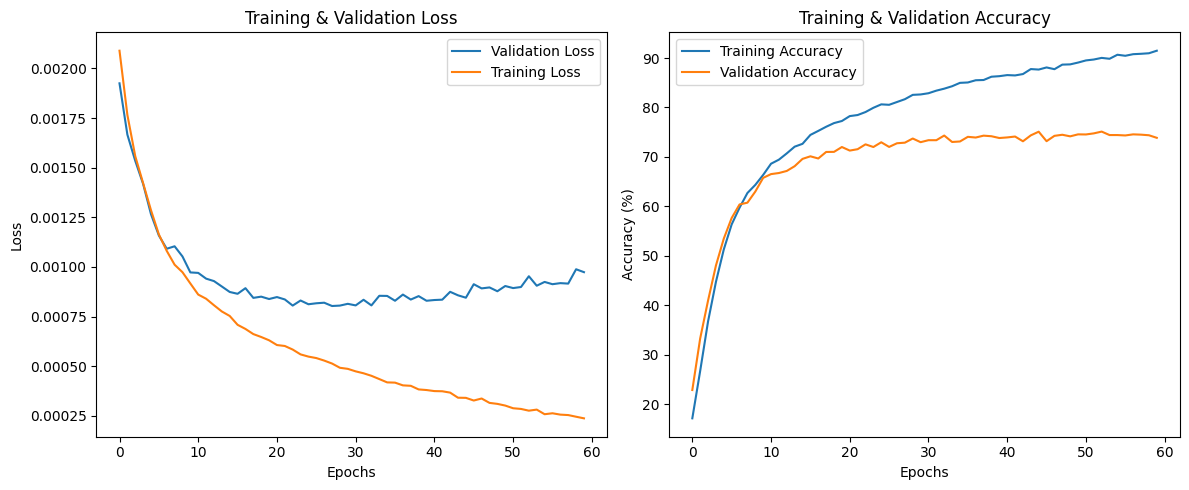

Finished Training #1


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

counter = 0
for params in params_config:
    
    counter += 1
    batch_size = params["batch_size"]
    max_epoch = params["max_epoch"]
    learning_rate = params["learning_rate"]
    loss_function = params["loss_function"]
    optimizer_function = params["optimizer"]

    # Build the DataLoaders
    train_loader, val_loader, test_loader, classes = get_dataloaders(batch_size)

    # Initialize the model, loss function, optimizer, and scheduler
    model = MnasNetA1(len(classes)).to(device)  # Adjust the number of classes based on your dataset
    criterion = loss_function
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)

    # Very important to use DataParallel to use multiple GPUs
    model = nn.DataParallel(model)

    # Create lists to store metrics
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []

    # # Create a second y-axis
    # fig, ax1 = plt.subplots()

    # color = 'tab:red'
    # ax1.set_xlabel('Epoch')
    # ax1.set_ylabel('Validation Accuracy', color=color)
    # ax1.tick_params(axis='y', labelcolor=color)

    # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    # color = 'tab:blue'
    # ax2.set_ylabel('Loss / Train Accuracy', color=color)  # we already handled the x-label with ax1
    # ax2.tick_params(axis='y', labelcolor=color)

    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.show(block=False)

    # Training loop
    for epoch in range(max_epoch):  # Loop over the dataset multiple times
        train_loss = 0.0
        train_correct = 0
        total_samples = 0

        # Use tqdm to create a progress bar for the training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}", unit="batch") as progress_bar:
            for i, data in enumerate(progress_bar):
                # Get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                ########################################################################################
                # Training the model

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step() 

                ########################################################################################   

                # Calculate loss & accuracy
                train_loss += loss.item()
                total_samples += labels.size(0)
                tot_train_loss = train_loss / total_samples
                _, predicted = torch.max(outputs.data, 1)
                train_correct += (predicted == labels).sum().item()
                train_acc = 100 * train_correct / total_samples

                # Update progress bar
                progress_bar.set_postfix(loss=tot_train_loss, accuracy=train_acc)

        # Validation
        val_correct = 0
        val_loss = 0
        val_total_samples = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_total_samples += labels.size(0)
                tot_val_loss = val_loss / val_total_samples
                _, predicted = torch.max(outputs.data, 1)

                # Calculate accuracy
                val_correct += (predicted == labels).sum().item()
                val_accuracy = 100 * val_correct / val_total_samples

        # Calculate average validation loss
        val_loss_list.append(tot_val_loss)
        train_loss_list.append(tot_train_loss)
    
        val_accuracy_list.append(val_accuracy)
        train_accuracy_list.append(train_acc)

        # Optionally, you can print or log other metrics at the end of each epoch
        print(f"Epoch {epoch+1}/{max_epoch}, Train Loss: {tot_train_loss:.2f}, Train acc: {train_acc:.2f}, Val Loss: {tot_val_loss:.2f}, 'Val acc: {val_accuracy:.2f}%', ")
        
    # Plotting the metrics
    plt.figure(figsize=(12, 5))

    # Plot for training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(val_loss_list, label='Validation Loss')
    plt.plot(train_loss_list, label='Training Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot for training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
        
    print(f"Finished Training #{counter}")

### (3) Evaluate the model and report performance using the test dataset


Finished Predictions
Accuracy of the network on the test images: 73 %


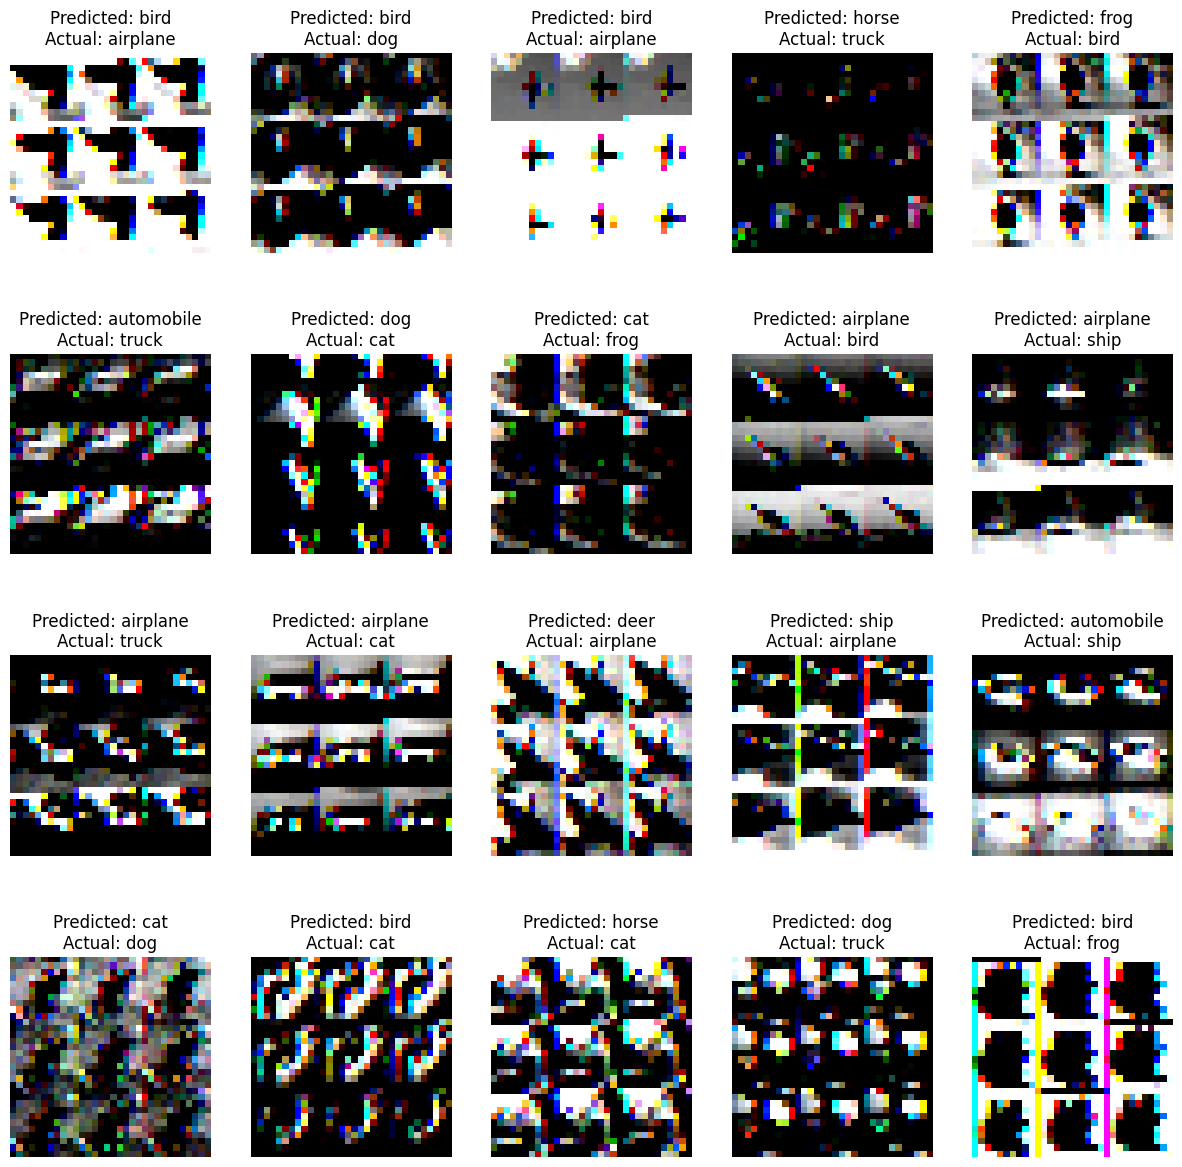

In [48]:
# Switch model to evaluation mode
model.eval()

# Lists to store wrongly predicted images and labels
wrong_images = []
wrong_labels = []
predicted_labels = []
correct = 0
total = 0

# No need to track gradients for prediction, so wrap in no_grad to save memory
with torch.no_grad():
    # Loop over all batches in the test_loader
    for data in test_loader:
        # Move the images and labels to the device (GPU or CPU)
        images, labels = data[0].to(device), data[1].to(device)
        # Pass the images through the model to get the outputs
        outputs = model(images)
        # Get the predicted class for each image by finding the index of the maximum value in the outputs
        _, predicted = torch.max(outputs.data, 1)
        # Increment the total count by the number of images in the current batch
        total += labels.size(0)
        # Increment the correct count by the number of images that were correctly classified
        correct += (predicted == labels).sum().item()
        
        # Compare the predicted labels with the actual labels, resulting in a boolean tensor where True indicates a wrong prediction
        wrong_preds = (predicted != labels)
        # Extend the wrong_images list with the images that were wrongly predicted
        wrong_images.extend(images[wrong_preds].tolist())
        # Extend the wrong_labels list with the actual labels of the images that were wrongly predicted
        wrong_labels.extend(labels[wrong_preds].tolist())
        # Extend the predicted_labels list with the predicted labels of the images that were wrongly predicted
        predicted_labels.extend(predicted[wrong_preds].tolist())

print('Finished Predictions')
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

# Select 20 random indices from the list of wrong predictions
indices = np.random.choice(len(wrong_images), 20)

# Plot the images
fig, axes = plt.subplots(4, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    # Convert the image data to a 28x28 array
    img = np.array(wrong_images[indices[i]]).reshape(32, 32, 3)
    # Plot the image
    ax.imshow(img)
    # Set the title to the predicted label and the actual label
    ax.set_title(f'Predicted: {predicted_labels_txt[indices[i]]}\nActual: {wrong_labels_txt[indices[i]]}')
    # Remove the axis
    ax.axis('off')

plt.show()

In [49]:
# Use list comprehension to map the numerical class indices to class names
wrong_labels_txt = [classes[i] for i in wrong_labels]
predicted_labels_txt = [classes[i] for i in predicted_labels]

### Histogram

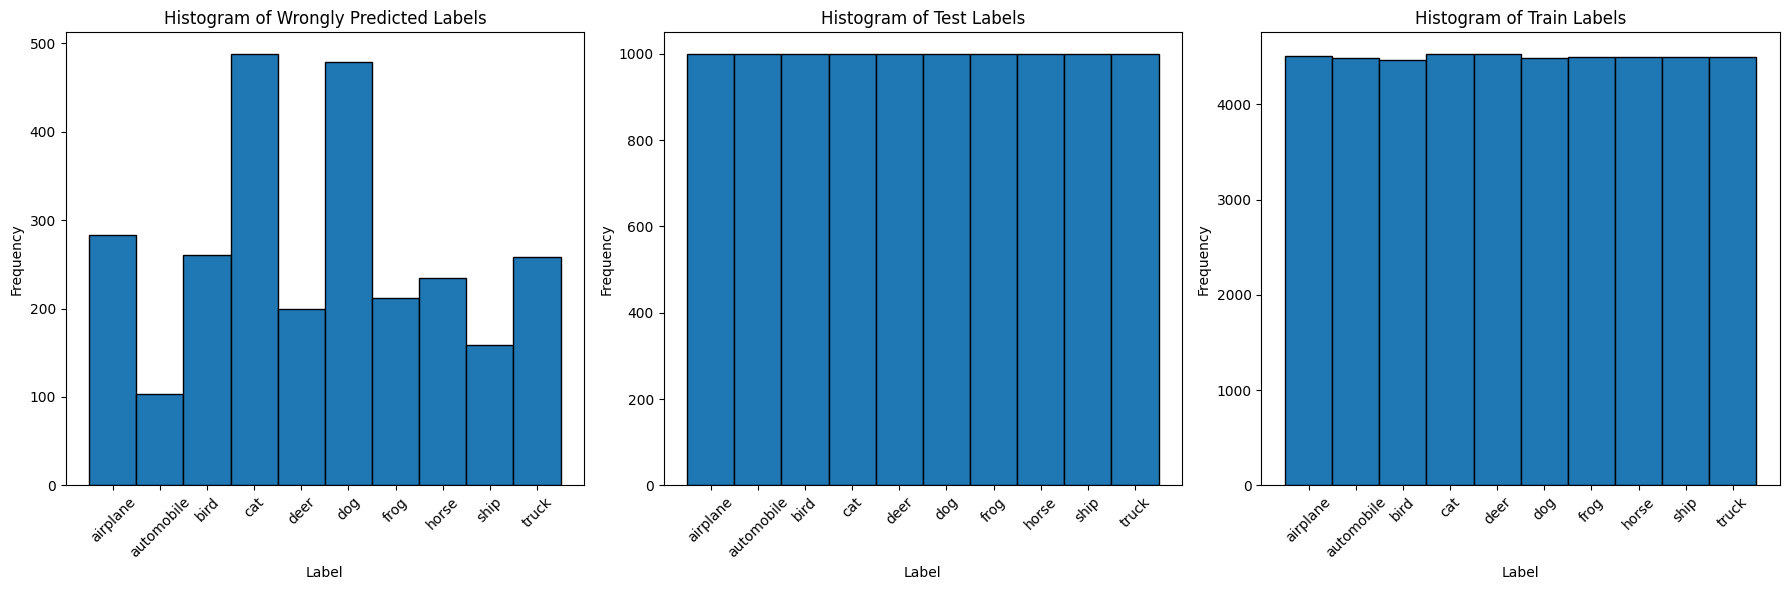

In [50]:
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.tolist())

train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.tolist())

# Convert the lists of predicted and actual labels to numpy arrays
wrong_labels_np = np.array(wrong_labels)
test_labels_np = np.array(test_labels)
train_labels_np = np.array(train_labels) 

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a histogram of the wrong labels in the first subplot
axes[0].hist(wrong_labels_np, bins=np.arange(wrong_labels_np.min(), wrong_labels_np.max()+2) - 0.5, edgecolor='black')
axes[0].set_title('Histogram of Wrongly Predicted Labels')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes, rotation=45)

# Create a histogram of the test labels in the second subplot
axes[1].hist(test_labels_np, bins=np.arange(test_labels_np.min(), test_labels_np.max()+2) - 0.5, edgecolor='black')
axes[1].set_title('Histogram of Test Labels')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes, rotation=45)

# Create a histogram of the train labels in the third subplot
axes[2].hist(train_labels_np, bins=np.arange(train_labels_np.min(), train_labels_np.max()+2) - 0.5, edgecolor='black')
axes[2].set_title('Histogram of Train Labels')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(range(len(classes)))
axes[2].set_xticklabels(classes, rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

### Summary

My 2nd assignment for the ENGR 8140 class is documented in this file. The achieved accuracy with the test dataset is 73%.
After the training cell, there is a plot which shows the loss and accuracy changes over the epochs during training.
Unfortunately, I was not able to increase the accuracy with different learning rates, epochs, batch sizes or different loss- and optimizer functions. Somehow, the accuracy with the test dataset is always stuck at 73%. Additionally, I plotted randomly some of the wrongly predicted images. As well, I made a histogram of the frequency from the wrongly predicted images. Surprisingly, cats and dogs often got predicted wrong.